# Семинар по деревьям

Берем данные boston, с которыми работали раньше

In [25]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston
import re
from sklearn.cross_validation import train_test_split

In [2]:
boston = load_boston()

In [3]:
boston.keys()

dict_keys(['data', 'target', 'DESCR', 'feature_names'])

In [4]:
X_tr, X_te, y_tr, y_te = train_test_split(boston["data"], boston["target"])

In [6]:
data_train = pd.DataFrame(X_tr, columns=boston["feature_names"])
data_test = pd.DataFrame(X_te, columns=boston["feature_names"])

In [7]:
data_train.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.06911,45.0,3.44,0.0,0.437,6.739,30.8,6.4798,5.0,398.0,15.2,389.71,4.69
1,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
2,0.03584,80.0,3.37,0.0,0.398,6.290,17.8,6.6115,4.0,337.0,16.1,396.90,4.67
3,0.14103,0.0,13.92,0.0,0.437,5.790,58.0,6.3200,4.0,289.0,16.0,396.90,15.84
4,0.54452,0.0,21.89,0.0,0.624,6.151,97.9,1.6687,4.0,437.0,21.2,396.90,18.46


In [8]:
data_train.shape

(379, 13)

In [9]:
from matplotlib import pyplot as plt
%matplotlib inline

Далее мы будем реализовывать первый шаг в построении решающего дерева - выбор признака и порога для разделения в корне дерева. Мы будем писать максимально понятный, но не оптимальный, код, т. е. в sklearn все реализовано более эффективно.

In [10]:
# чтобы было удобно сортировать объекты вместе с целевым вектором, допишем его в датафрейм
data_train["target"] = y_tr

In [11]:
# чтобы было удобно перебирать порог на первый признак, сортируем датафрейм по нему
data_train.sort_values("CRIM", inplace=True)

In [12]:
data_train.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
202,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
75,0.01096,55.0,2.25,0.0,0.389,6.453,31.9,7.3073,1.0,300.0,15.3,394.72,8.23,22.0
290,0.01301,35.0,1.52,0.0,0.442,7.241,49.3,7.0379,1.0,284.0,15.5,394.74,5.49,32.7
294,0.01311,90.0,1.22,0.0,0.403,7.249,21.9,8.6966,5.0,226.0,17.9,395.93,4.81,35.4
304,0.01360,75.0,4.00,0.0,0.410,5.888,47.6,7.3197,3.0,469.0,21.1,396.90,14.80,18.9


In [13]:
# считаем качество - дисперсию ответов в левом и правом поддереве с весами, как в лекции
quals = []
for i in range(data_train.shape[0]):
    quality = data_train["target"][:i].std()**2 * i/data_train.shape[0] + data_train["target"][i:].std()**2 * (1-i/data_train.shape[0])
    quals.append(quality)

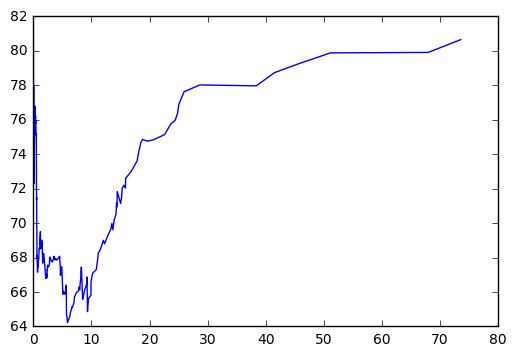

In [14]:
# рисуем график порог - качество разделения
plt.plot(data_train["CRIM"], quals)

Чем меньше, тем лучше, поэтому оптимум остигается где-то в CRIM = 7.

Теперь сделаем это для каждого признака (copypaste - это очень плохо, но для демонстрации хорошо).

Обратите внимание: чтобы было удобно сравнивать значение критерия для разных признаков, мы все рисуем на одном графике. Но шкала (множество значений) у каждого признака своя. Так что мы будем откладывать по оси x просто числа от 0 до длины выборки, и величину оптимального порога по графику будет определить нельзя. По графику мы сможем определить только оптимальный признак для разделения.

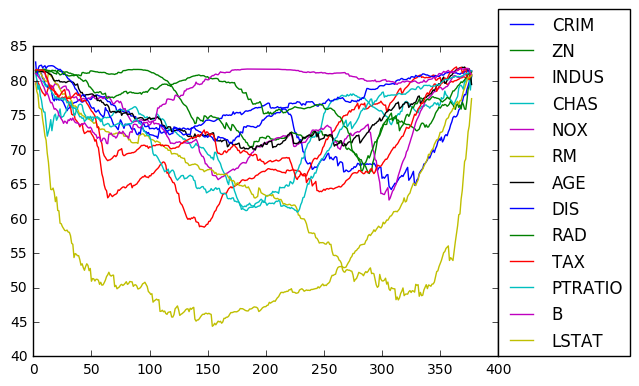

In [19]:
for feat in data_train.columns[:-1]:
    quals = []
    data_train.sort_values(feat, inplace=True)
    for i in range(data_train.shape[0]):
        quality = data_train["target"][:i].std()**2 * i/data_train.shape[0] + data_train["target"][i:].std()**2 * (1-i/data_train.shape[0])
        quals.append(quality)
    plt.plot(quals, label=feat)
plt.legend(loc=(1, 0))

Кажется, выиграл RM. Нарисуем для него график отдельно (уже с его осью): 

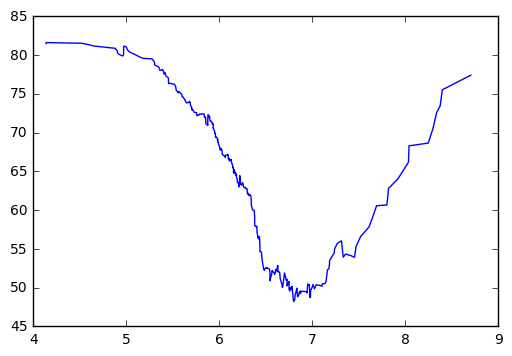

In [23]:
feat = "RM"
quals = []
data_train.sort_values(feat, inplace=True)
for i in range(data_train.shape[0]):
    quality = data_train["target"][:i].std()**2 * i/data_train.shape[0] + data_train["target"][i:].std()**2 * (1-i/data_train.shape[0])
    quals.append(quality)
plt.plot(data_train[feat], quals, label=feat)

Величина порога:

In [27]:
thresh = data_train[feat][np.argmin(quals)]
print(thresh)

6.739


Нарисуем выборку в осях RM - target и изобразим порог, по которому мы разделили

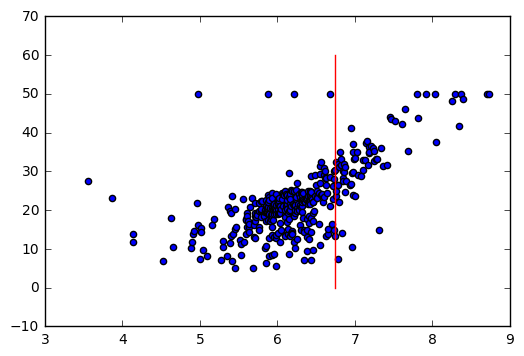

In [29]:
plt.scatter(data_train["RM"], data_train["target"])
plt.plot([thresh, thresh], [0, 60], color="red")

Видно, что точки справа от красной линии лежат почти все выше 30, а слева - ниже, т. е. этот признак действительно очень хорошо разделяет выборку.